# Microlensing Hierarchical Model
## DSFP Hack Session 16
### 23 September 2022

Chang, Rad, and Tony -- microlensing group

# 0. Imports

In [59]:
import pathlib

import astropy.coordinates as coord
import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import daft
from pyia import GaiaData
import arviz as az
import pymc as pm

In [60]:
from matplotlib import rc
rc('font', **{'family':'serif', 'size': 16})
rc('text', usetex=False)

### Constants

In [140]:
Msun = 2e33
G = 6.67e-8
c = 3e10
kpc = 3e21

# 1. Helper Functions and Mock Data

In [61]:
def A(t, t0, u0, tE):
    u = np.sqrt(u0**2 + (t - t0)**2/tE**2)
    return (u**2 + 2)/u/np.sqrt(u**2 + 4)

In [62]:
def F(t, t0, u0, tE, Fs, Fb):
    return Fs*A(t, t0, u0, tE) + Fb

In [142]:
t_mock = np.arange(1, 1000, 10)
F_sig_mock = (np.random.rand(len(t_mock))-0.5)/10
F_sig_sys = 0.1

params_mock = {'t0': 800, 'u0tE': 32, 'u0': 0.4, 'Fs': 1, 'Fb':0}
F_obs = F_sig_mock + F(t_mock, params_mock['t0'], params_mock['u0'], params_mock['u0tE']/params_mock['u0'], 1, 0)

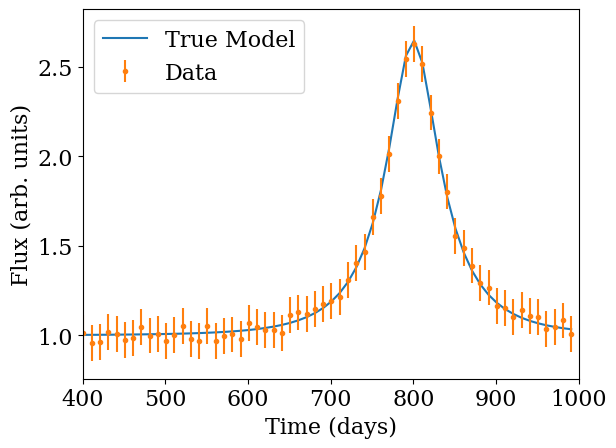

In [143]:
plt.plot(t_mock, F_obs - F_sig_mock, label='True Model')
plt.errorbar(t_mock, F_obs , yerr= F_sig_sys, label='Data', ls='none', marker='.')

plt.ylabel('Flux (arb. units)')
plt.xlabel('Time (days)')
plt.xlim(400, 1000)
plt.legend()
plt.show()

# 2. Simple Model

In [132]:
with pm.Model() as model:
    
    # priors
    t0 = pm.Uniform('t0', lower=0., upper=1000., initval=780)
    u0 = pm.Uniform('u0', lower=0., upper=1., initval=0.5)
    u0tE = pm.Uniform('u0tE', lower=0., upper=1000., initval=30)
    
#     Fs = pm.Uniform('Fs', lower=0., upper=2.)
#     Fb = pm.Uniform('Fb', lower=0., upper=2.)

    F_true = pm.Deterministic('F_true', F(t_mock, t0, u0, u0tE/u0, 1,0))
    
    # log_likelihood
    logl = pm.Normal('logl', mu=F_true, sigma=F_sig_sys, observed=F_obs)

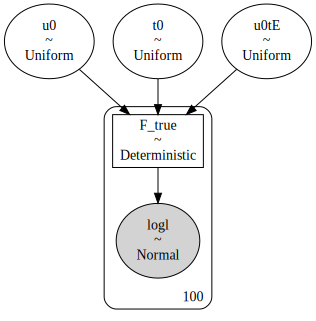

In [133]:
pm.model_to_graphviz(model)

# 3. Sampling

In [124]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t0, u0, u0tE]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [128]:
az.summary(idata, var_names=['u0','u0tE', 't0'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u0,0.402,0.010,0.384,0.421,0.000,0.000,2137.0,2280.0,1.0
u0tE,32.331,1.769,28.827,35.426,0.039,0.027,2099.0,2509.0,1.0
t0,800.287,1.353,797.549,802.655,0.027,0.019,2427.0,2600.0,1.0


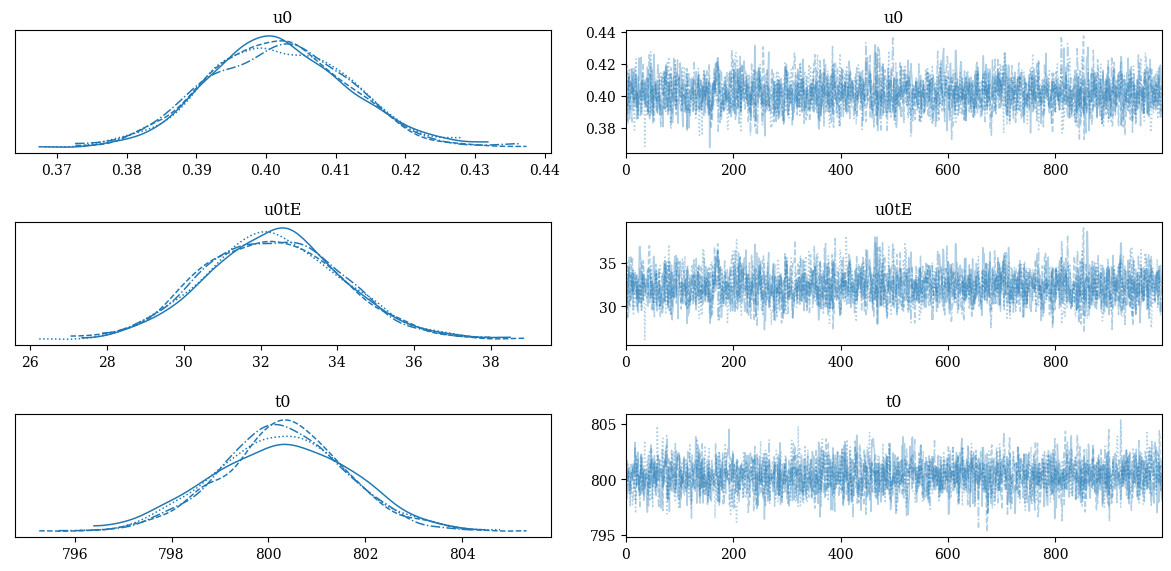

In [125]:
az.plot_trace(idata, var_names=['u0','u0tE', 't0'])
plt.tight_layout()

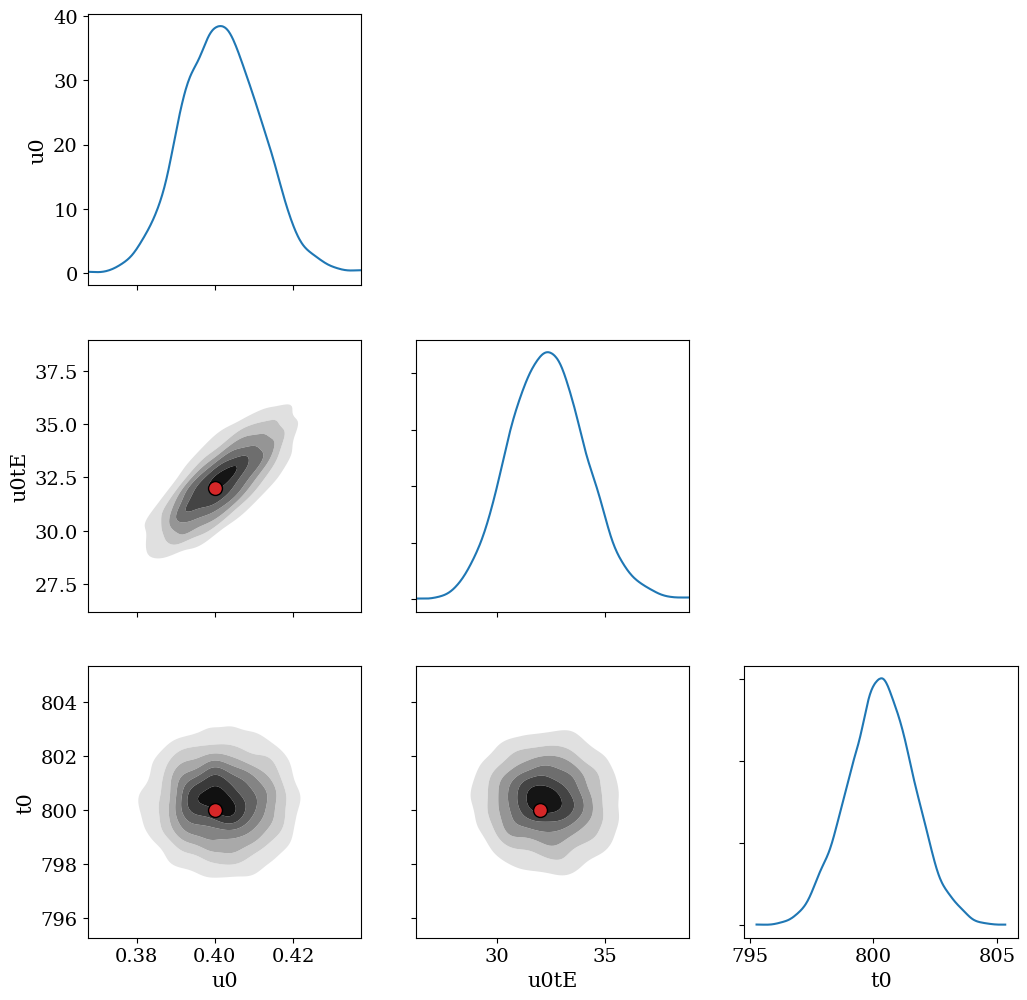

In [138]:
az.plot_pair(
    idata, 
    var_names=['u0','u0tE', 't0'], 
    marginals=True,
    kind="kde",
    kde_kwargs=dict(contourf_kwargs=dict(cmap="Greys"), contour_kwargs=dict(alpha=0.0)),
    figsize=(12, 12),
    reference_values=params_mock,
    reference_values_kwargs=dict(
        color="tab:red", markersize=10, label="true values", linestyle="none"
    )
)
plt.show()

# 4. Hierarchical Model

In [141]:
np.sqrt(4*G*Msun/kpc/c/c)

1.4058080581275298e-08

In [ ]:
with pm.Model() as modelH:
    
    # priors
    t0 = pm.Uniform('t0', lower=0., upper=1000., initval=780)
    u0 = pm.Uniform('u0', lower=0., upper=1., initval=0.5)
    u0tE = pm.Uniform('u0tE', lower=0., upper=1000., initval=30)
    
    u0tE = pm.Deterministic('u0tE', )

    F_true = pm.Deterministic('F_true', F(t_mock, t0, u0, u0tE/u0, 1,0))
    
    # log_likelihood
    logl = pm.Normal('logl', mu=F_true, sigma=F_sig_sys, observed=F_obs)